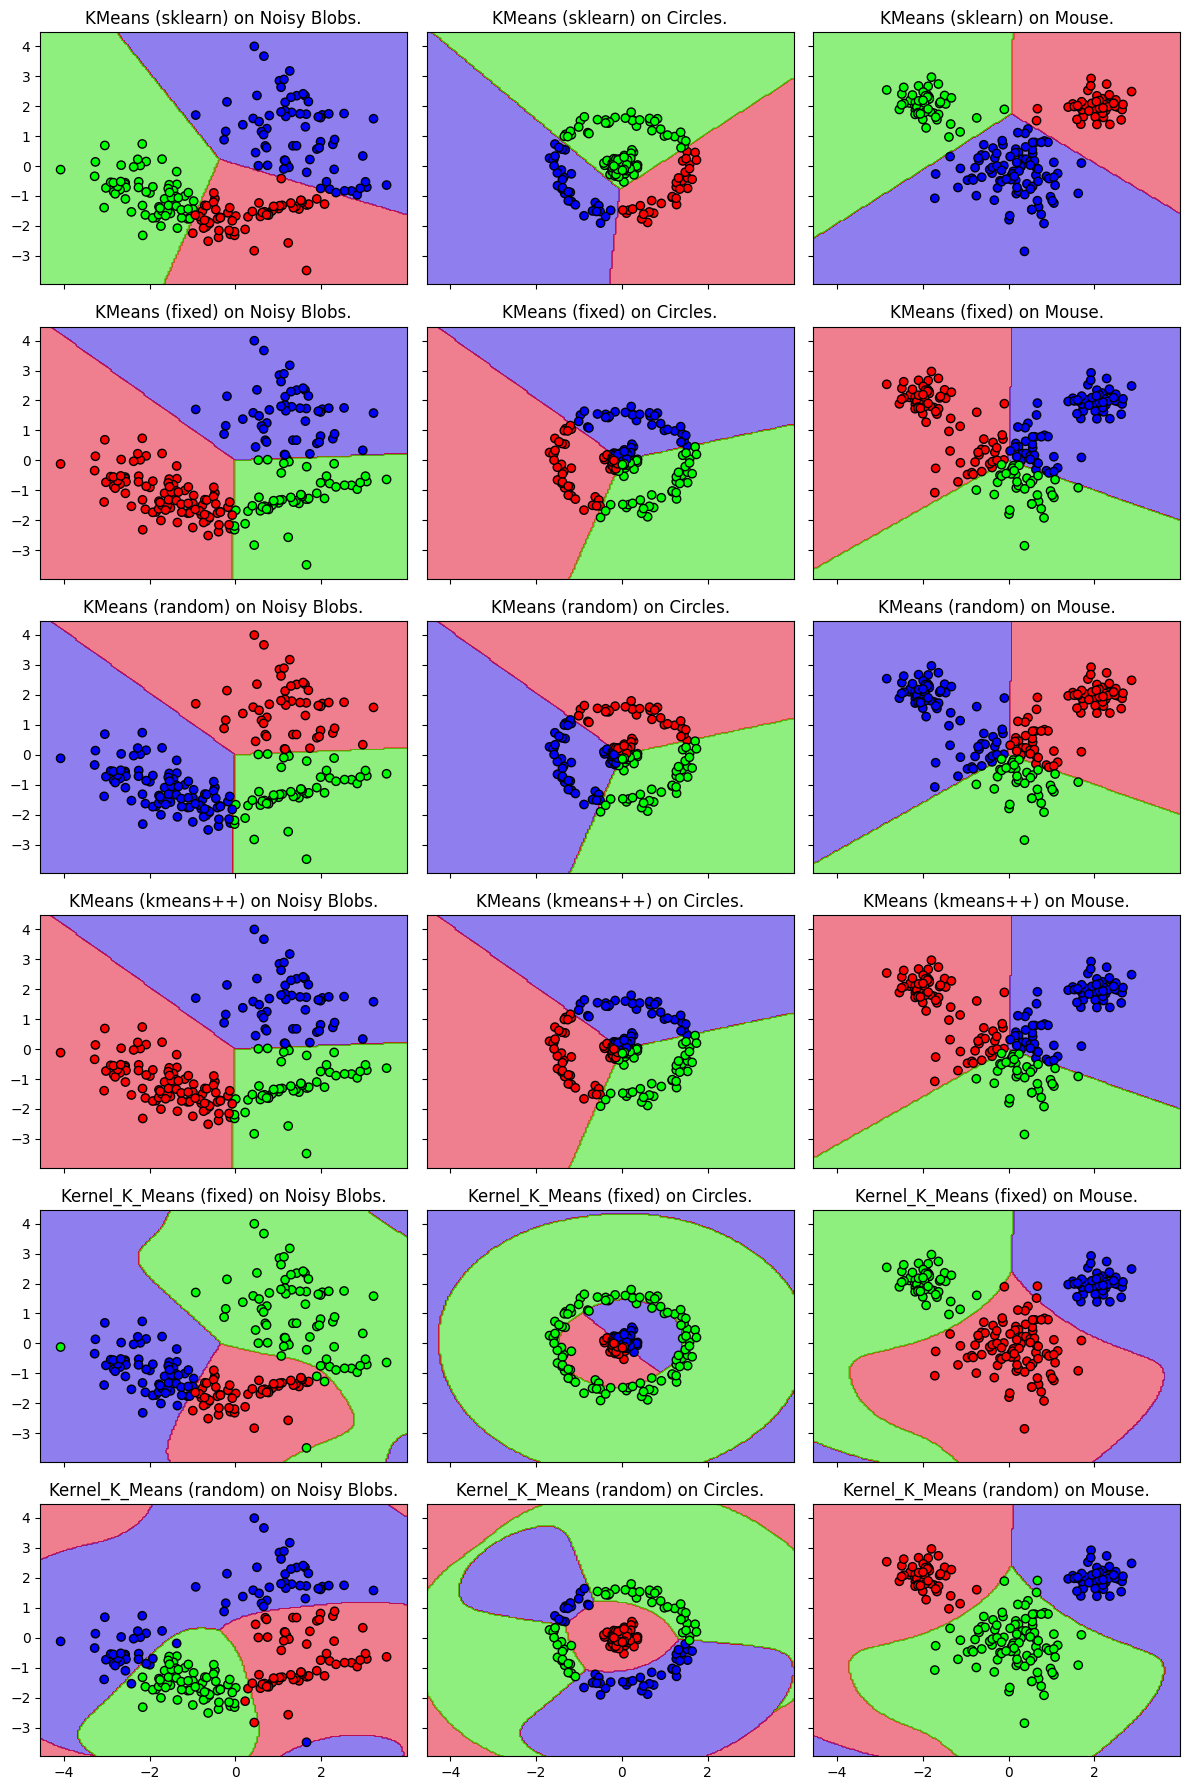

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.datasets import make_classification, make_circles, make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.base import BaseEstimator

from random import seed
from random import randint
import sys

class K_Means(BaseEstimator):
    def __init__(self, k, initial_centroids='random', max_iter=300):
        super(K_Means, self).__init__()

        self.k = k
        self.initial_centroids = initial_centroids
        self.max_iter = max_iter

    def fit(self, X):
      if (isinstance(self.initial_centroids, str)):
        if (self.initial_centroids == 'random'):
          idx = []
          for x in range(self.k):
            idx.append(randint(0, len(X)))
          self.initial_centroids = np.array(X[idx])

        elif(self.initial_centroids == 'Kmeans++'):
          centroids = []
          centroids.append(X[np.random.randint(X.shape[0]), :])
          for c_id in range(self.k - 1):
            dist = []
            for i in range(X.shape[0]):
              point = X[i, :]
              d = sys.maxsize
              for j in range(len(centroids)):
                temp_dist = np.sum((point - centroids[j])**2)
                d = min(d, temp_dist)
              dist.append(d)

            dist = np.array(dist)
            next_centroid = X[np.argmax(dist), :]
            centroids.append(next_centroid)
          self.initial_centroids = np.array(centroids)

      for x in range(self.max_iter):
        distances = np.sum(X**2) - 2*np.matmul(X, self.initial_centroids.transpose()) + np.sum(self.initial_centroids**2).transpose()
        out = np.argmin(np.array(distances), axis=1)

        for idx in range(self.k):
          self.initial_centroids[idx] = np.average(X[np.where(out == idx)], axis=0)

    def predict(self, X):
       return np.argmin(np.array(np.sum(X**2) - 2*np.matmul(X, self.initial_centroids.transpose()) + np.sum(self.initial_centroids**2).transpose()), axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

def RBF_Kernel(x, y):
    return np.exp(-(np.sum(x**2, axis=1, keepdims=True) - 2*np.matmul(x, y.transpose()) + np.sum(y**2, axis=1, keepdims=True).transpose())/(2*(0.75)**2))

class Kernel_K_Means(BaseEstimator):
    def __init__(self, k, kernel_func, initial_assignment=None, max_iter=300):
        super(Kernel_K_Means, self).__init__()

        self.k = k
        self.initial_assignment = initial_assignment
        self.max_iter = max_iter
        self.kernel_func = kernel_func

    def fit(self, X):
        self.data = X
        dist = RBF_Kernel(X, X)

        if (self.initial_assignment is None):
            labels = np.random.choice(np.arange(0, self.k), X.shape[0])
        else:
            labels = self.initial_assignment
        first_term  = dist[np.arange(len(X)), np.arange(len(X))]
        current_iter = 0
        labels_changed = np.infty
        while current_iter<self.max_iter and labels_changed>0:

            temp = np.zeros((self.k, len(X)))

            for i in range(self.k):
                inds = np.where(labels==i)[0]
                second_term = (-2 * dist[:,inds].sum(axis=1))/len(inds)
                third_term = (dist[inds][:,inds]).sum()/(len(inds)**2)
                temp[i] = first_term + second_term + third_term

            old_labels = labels
            labels = np.argmin(temp,axis=0)
            labels_changed = (labels!=old_labels).sum()
            current_iter+=1
        self.labels_ = labels

    def predict(self, X):
        dist = RBF_Kernel(X, self.data)
        labels = self.labels_
        first_term  = dist[np.arange(len(X))].mean(axis = 1)

        temp = np.zeros((self.k, len(X)))

        for i in range(self.k):
            inds = np.where(labels==i)[0]
            second_term = (-2 * dist[:,inds].sum(axis=1))/len(inds)
            third_term = (dist[inds][:,inds]).sum()/(len(inds)**2)
            temp[i] = first_term + second_term + third_term

        labels = np.argmin(temp,axis=0)
        return labels

    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)


def generate_data():
    n = 200
    n_classes = 3
    X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=n_classes, weights=(0.5, 0.3, 0.2),
                               class_sep=1.3, n_clusters_per_class=1, random_state=12345)
    yield ('Noisy Blobs', X)

    X, Y = make_circles(n, noise=0.08, factor=0.1, random_state=1234)
    yield ('Circles', X*1.6)

    X, Y = make_blobs([n//2, n//4, n//4], n_features=2, centers=[[0, 0], [-2, 2], [2, 2]],
                               cluster_std=[0.8, 0.35, 0.35], random_state=1234)
    yield ('Mouse', X)

datasets = list(generate_data())

initial_c = np.array([[ 1.57747042,  0.04248975],
                      [-1.38669281, -0.45473879],
                      [ 0.28039302, -0.2942349 ]])
initial_a = np.array([0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0,
                      2, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1,
                      1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 1, 0, 2, 0,
                      1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2,
                      1, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0,
                      2, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 1, 2, 1, 2, 2, 2,
                      2, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0, 0, 2,
                      1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 2, 1, 0])
clusterers = [('KMeans (sklearn)', KMeans(n_clusters=3, n_init=1, init='random')),
              ('KMeans (fixed)', K_Means(k=3, initial_centroids=initial_c)),
              ('KMeans (random)', K_Means(k=3, initial_centroids='random')),
              ('KMeans (kmeans++)', K_Means(k=3, initial_centroids='Kmeans++')),
              ('Kernel_K_Means (fixed)', Kernel_K_Means(k=3, kernel_func = RBF_Kernel, initial_assignment=initial_a)),
              ('Kernel_K_Means (random)', Kernel_K_Means(k=3, kernel_func = RBF_Kernel)),
             ]


res = 200  # Resolution of the grid in cells
x_max, y_max = np.max(np.stack([np.max(X, axis=0) for _, X in datasets]), axis=0)
x_min, y_min = np.min(np.stack([np.min(X, axis=0) for _, X in datasets]), axis=0)
x_min, x_max = x_min - (x_max - x_min) * 0.0625, x_max + (x_max - x_min) * 0.0625
y_min, y_max = y_min - (y_max - y_min) * 0.0625, y_max + (y_max - y_min) * 0.0625
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]

cmap = colors.ListedColormap([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]])
rows = len(clusterers)
columns = len(datasets)
fig, axes = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(12, 9/columns*rows), squeeze=False)
for (clu_name, clu), row_axes in zip(clusterers, axes):
    for (ds_name, X), ax in zip(datasets, row_axes):
        clusters = clu.fit_predict(X)
        if hasattr(clu, 'predict'):
            grid_out = clu.predict(grid_input).reshape(grid_x.shape)
            ax.contourf(grid_x, grid_y, grid_out%4, alpha=0.5, cmap=plt.cm.brg, vmin=0, vmax=2)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        ax.set_title(f'{clu_name:s} on {ds_name:s}.')
        ax.scatter(X[:, 0], X[:, 1], c=cmap(clusters%4), edgecolor='k')
fig.tight_layout()
plt.show()
plt.close(fig)